<a href="https://colab.research.google.com/github/jazbengu/COS711-ASSIGNMENT-TWO/blob/main/Joy_Bengu_25000307_COS711_Assignment_Two_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
#!pip install scikeras
#!pip install --force-reinstall tensorflow
#!pip install --force-reinstall keras

print(tf.__version__)



2.17.0


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers import Optimizer
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt




In [5]:

def load_data(file_path):
    data = pd.read_csv(file_path)
    imputer = SimpleImputer(strategy='mean')
    data.iloc[:, :-1] = imputer.fit_transform(data.iloc[:, :-1])  # Assuming last column is labels

    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    y = pd.get_dummies(y).values

    return X, y

def preprocess_data(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test


In [47]:
class RProp(Optimizer):
    def __init__(self, learning_rate=0.01, eta_plus=1.2, eta_minus=0.5,
                 min_step=1e-6, max_step=50, **kwargs):
        super(RProp, self).__init__(learning_rate=learning_rate, **kwargs)
        self.eta_plus = eta_plus
        self.eta_minus = eta_minus
        self.min_step = min_step
        self.max_step = max_step

    def _create_slots(self, var_list):
        for var in var_list:
            self.add_slot(var, "prev_grad")
            self.add_slot(var, "step")

    def update_step(self, gradient, variable):
        prev_grad = self.get_slot(variable, "prev_grad")
        step = self.get_slot(variable, "step")

        # RProp update logic
        change = tf.sign(gradient * prev_grad)
        new_step = tf.clip_by_value(
            tf.where(change > 0, step * self.eta_plus, tf.where(change < 0, step * self.eta_minus, step)),
            self.min_step,
            self.max_step
        )
        update = -tf.sign(gradient) * new_step

        # Update the variable (weights)
        variable.assign_add(update)

        # Update the slots for future iterations
        prev_grad.assign(gradient)
        step.assign(new_step)

    def _resource_apply_dense(self, grad, var):
        self.update_step(grad, var)

    def _resource_apply_sparse(self, grad, var, indices):
        raise NotImplementedError("Sparse gradient updates are not supported.")

    def get_config(self):
        base_config = super(RProp, self).get_config()
        return {
            **base_config,
            "learning_rate": self.learning_rate,
            "eta_plus": self.eta_plus,
            "eta_minus": self.eta_minus,
            "min_step": self.min_step,
            "max_step": self.max_step,
        }

In [22]:
def create_model(optimizer='adam', learning_rate=0.001, activation='relu'):
    model = Sequential()
    model.add(Dense(128, input_dim=13, activation=activation))  # 12 input features
    model.add(Dense(64, activation=activation))
    model.add(Dense(3, activation='softmax'))  # 3 classes

    # Initialize the optimizer based on the chosen or default optimizer type
    if optimizer == 'adam':
        # Providing a default learning rate for Adam if not specified
        learning_rate = learning_rate or 0.001
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        # Providing a default learning rate for SGD if not specified
        learning_rate = learning_rate or 0.001
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'Rprop':  # Use RProp Optimizer
       opt = RProp(learning_rate)
    else:
        raise ValueError("Unsupported optimizer type")

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [8]:
from scikeras.wrappers import KerasClassifier
def perform_grid_search(X_train, y_train):
    model = KerasClassifier(build_fn=create_model, verbose=0)
    param_grid = {
        'batch_size': [5, 10, 20],
        'epochs': [5, 10]
    }

    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X_train, y_train)

    print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

    # Plotting results
    results_df = pd.DataFrame(grid_result.cv_results_)
    results_pivot = results_df.pivot_table(index='param_batch_size', columns='param_epochs', values='mean_test_score')

    plt.figure(figsize=(8, 6))
    sns.heatmap(results_pivot, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title("Hyperparameter Tuning: Batch Size vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Batch Size")
    plt.show()

    return grid_result.best_estimator_

In [11]:
def train_and_compare_algorithms(X_train, y_train, X_test, y_test):
    adam_model = create_model(optimizer='adam', learning_rate=0.001)
    history_adam = adam_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=20)

    sgd_model = create_model(optimizer='sgd', learning_rate=0.001)
    history_sgd = sgd_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=20)

    rprop_model = create_model(optimizer='Rprop')
    history_rprop = rprop_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=20)

    plt.plot(history_adam.history['val_loss'], label='Adam')
    plt.plot(history_sgd.history['val_loss'], label='SGD')
    plt.plot(history_rprop.history['val_loss'], label='Rprop')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.show()



In [13]:
def hybrid_learning(X_train, y_train, X_test, y_test):
    # Train individual models
    adam_model = create_model(optimizer='adam', learning_rate=0.001)
    adam_model.fit(X_train, y_train, epochs=20, batch_size=20, verbose=0)

    sgd_model = create_model(optimizer='sgd', learning_rate=0.001)
    sgd_model.fit(X_train, y_train, epochs=20, batch_size=20, verbose=0)

    rprop_model = create_model(optimizer='Rprop')
    rprop_model.fit(X_train, y_train, epochs=20, batch_size=20, verbose=0)

    # Ensemble predictions by averaging
    adam_pred = adam_model.predict(X_test)
    sgd_pred = sgd_model.predict(X_test)
    rprop_pred = rprop_model.predict(X_test)

    # Average predictions from the models
    ensemble_pred = (adam_pred + sgd_pred + rprop_pred) / 3
    ensemble_pred = np.argmax(ensemble_pred, axis=1)  # Assuming classification

    y_test_labels = np.argmax(y_test, axis=1)  # Get true labels
    accuracy = np.mean(ensemble_pred == y_test_labels)

    print(f"Ensemble model accuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best: 0.9656540600906299 using {'batch_size': 5, 'epochs': 10}


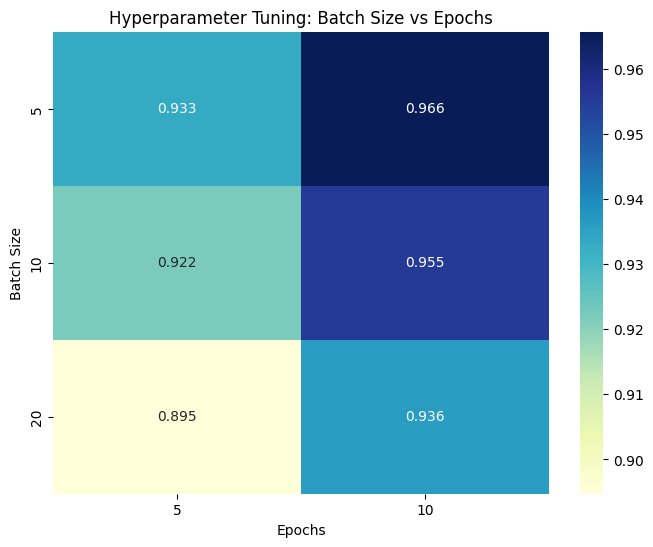

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6201 - loss: 0.8725 - val_accuracy: 0.7897 - val_loss: 0.5595
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7968 - loss: 0.5344 - val_accuracy: 0.8378 - val_loss: 0.4339
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8382 - loss: 0.4313 - val_accuracy: 0.8841 - val_loss: 0.3542
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9012 - loss: 0.3197 - val_accuracy: 0.9055 - val_loss: 0.2839
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9082 - loss: 0.2623 - val_accuracy: 0.9073 - val_loss: 0.2512
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9305 - loss: 0.2161 - val_accuracy: 0.8984 - val_loss: 0.2357
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9341 - loss: 0.1912 - val_accuracy: 0.9251 - val_loss: 0.1985
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9518 - loss: 0.1666 - val_accuracy: 0.9376 - val_

TypeError: RProp.update_step() takes 3 positional arguments but 4 were given

In [48]:
def main():
    X, y = load_data('Almond.csv')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_test = preprocess_data(X_train, X_test)

    best_model = perform_grid_search(X_train, y_train)
    train_and_compare_algorithms(X_train, y_train, X_test, y_test)
    hybrid_learning(X_train, y_train, X_test, y_test)

if __name__ == "__main__":
    main()